In [1]:
import FinanceDataReader as fdr
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:,.3f}'.format

### 거래량이 종종 터지며, 매집의 흔적을 보인다.    

양봉이면서 거래량이 갑자기 증가하는 날을 카운트하고, 수익율과의 상관관계를 보겠습니다.

In [3]:
mdl_data = pd.read_pickle('mdl_data.pkl')
mdl_data.head().style.set_table_attributes('style="font-size: 12px"')

,open,high,low,close,volume,change,code,name,kosdaq_return,return,win_market,close_r1,close_r2,close_r3,close_r4,close_r5,max_close
2021-01-05,2270,2285,2200,2250,410263,-0.004425,060310,3S,1.008326,0.995575,0,1.017778,1.017778,0.997778,0.966667,0.971111,1.017778
2021-01-06,2225,2310,2215,2290,570349,0.017778,060310,3S,0.995567,1.017778,1,1.000000,0.980349,0.949782,0.954148,0.949782,1.000000
2021-01-07,2290,2340,2240,2290,519777,0.000000,060310,3S,1.007612,1.000000,0,0.980349,0.949782,0.954148,0.949782,0.958515,0.980349
2021-01-08,2300,2315,2225,2245,462568,-0.019651,060310,3S,0.998918,0.980349,0,0.968820,0.973274,0.968820,0.977728,0.973274,0.977728
2021-01-11,2230,2275,2130,2175,409057,-0.031180,060310,3S,0.988702,0.968820,0,1.004598,1.000000,1.009195,1.004598,1.002299,1.009195


In [4]:
kosdaq_list = pd.read_pickle('kosdaq_list.pkl')

data_h4 = pd.DataFrame()

for code in kosdaq_list['code']:

    data = mdl_data[mdl_data['code']==code].sort_index().copy()
    
    data['volume_mean'] = data['volume'].rolling(60).mean() # 60일 이동평균값
    data['volume_std'] = data['volume'].rolling(60).std() # 60일 이동평균값
    data['volume_z'] = (data['volume'] - data['volume_mean'])/data['volume_std'] # 거래량은 종목과 주가에 따라 다르기 떄문에 표준화한 값이 필요함
    data['z>1.96'] = (data['close'] > data['open'])*(data['volume_z'] > 1.65).astype(int) # 양봉이면서 거래량이 90%신뢰구간을 벗어난 날
    data['num_z>1.96'] =  data['z>1.96'].rolling(60).sum()  # 양봉이면서 거래량이 90% 신뢰구간을 벗어난 날을 카운트
       
    data['max_close']  = data[['close_r1','close_r2','close_r3','close_r4','close_r5']].max(axis=1) # 5 영업일 종가 수익율 중 최고 값
    data.dropna(subset=['volume_mean','close_r1','close_r2','close_r3','close_r4','close_r5'], inplace=True) # missing 이 있는 행은 제거  
    
    data_h4 = pd.concat([data, data_h4], axis=0)

data_h4.to_pickle('data_h4.pkl')  

<br> 거래량이 갑자기 많아지고 양봉인 날을 카운트하고 그 갯 수에 따라 수익율의 변화를 봤습니다. 전체적으로 거래량이 갑자기 증가하는 날이 많을 수 록 수익율이 증가하는 패턴을 보여줍니다. 결과의 마지막 num_z 가 15일인 경우는 수익율이 급강하했는데요. 실제로 너무 많으면 수익율이 안 좋은 것인지 여부는 해당 레코드 수(47개)가 많지 않아 신뢰하기 어렵습니다.  

             count  mean
num_z>1.96              
0.000       105320 1.027
1.000        78911 1.031
2.000        57860 1.032
3.000        39476 1.035
4.000        25244 1.035
5.000        15428 1.038
6.000         9250 1.040
7.000         4841 1.045
8.000         3210 1.048
9.000         1505 1.044
10.000         904 1.046
11.000         450 1.047
12.000         318 1.035
13.000          56 1.046
14.000          94 1.048
15.000          47 1.002


<AxesSubplot:xlabel='num_z>1.96'>

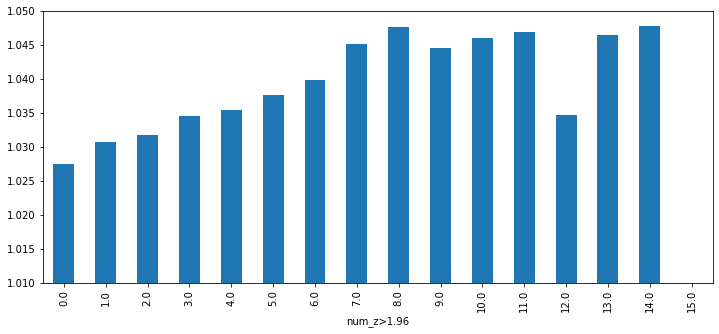

In [6]:
data_h4 = pd.read_pickle('data_h4.pkl') 
print(data_h4.groupby('num_z>1.96')['max_close'].agg(['count','mean']))
data_h4.groupby('num_z>1.96')['max_close'].mean().plot(figsize=(12,5), kind='bar', ylim=(1.01, 1.05))